# k-means++, k-medoids and c-means LAB.7 Solutions

In this lab we implement various variants of k-means.

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # for plotting
from scipy.spatial.distance import cdist # for distances calculation

## Exercise 1

Let's now implement the k-means class, we follow a similar approach to the one of the last lab.

In [108]:
class KMeans(object):

    def __init__(self, n_clusters, init='random', max_iter=300, center_type='centroids'):

        initializations = ['random', 'kmeans++']
        center_types = ['centroids', 'medoids']

        if init not in initializations:
            raise ValueError(f'possible initializations include {initializations}')

        if center_type not in center_types:
            raise ValueError(f'possible center types include {center_types}')

        self.init = init
        self.center_type = center_type

        if isinstance(n_clusters, int):
            self.n_clusters = n_clusters
        else:
            ValueError('expected int for n_clusters')

        self.max_iter = max_iter


    def fit(self, X):
        
        # save data
        self._X_fit = X

        # extract number of features and dimensions
        n_feats, dims = X.shape

        # intialize kmeans
        centers = self._initialize(X)

        # epochs + old_labels
        epoch = 0
        old_labels = np.zeros(n_feats, )

        while True:

            # find the distances
            dists = cdist(X, centers)

            # find the labels
            labels = np.argmin(dists, axis=-1)

            # update centroids
            centers = self._calculate_center(X, labels)

            # breaking if no change in the labels:
            if np.allclose(labels, old_labels):
                break

            # breaking at maximum iteration
            if epoch == self.max_iter:
                break
            
            # update
            old_labels = labels
            epoch += 1


        # saving variables
        self.centers = centers
        self.labels = labels
        self.set_labels = set(labels)
        self.loss = np.sum(dists.min(axis=-1))
        self.final_epoch = epoch

    def _initialize(self, X):
        """ Initialization routine """
        if self.init == 'random':
            idxs = np.random.choice(len(X), size=self.n_clusters, replace=False)
            return X[idxs]
        
        elif self.init == 'kmeans++':
            centers = []

            # first chosen randomly
            rand_idx = np.random.choice(len(X), size=1, replace=False)
            centers.append(X[rand_idx].ravel())

            # the other one are chosen accordingly to a prob distr
            for idx in range(1, self.n_clusters):

                # calculate distances
                dists = cdist(X, np.array(centers))

                # get minimum and square
                min_dists = np.min(dists, axis=-1) ** 2

                # chose new one accordingly to probability distribution
                probs = min_dists / min_dists.sum()
                rand_idx = np.random.choice(len(X), size=1, replace=False, p=probs)
                centers.append(X[rand_idx].ravel())

            return np.array(centers)

        else:
            raise NotImplementedError()

    def _calculate_center(self, X, labels):
        """ Calculate centers routine """

        if self.center_type == 'centroids':
            return np.array([np.mean(X[labels==k], axis=0) for k in set(labels)])

        if self.center_type == 'medoids':
            centers = []
            for k in range(self.n_clusters):
                # extract points in cluster k
                pts = X[labels==k]
                # compute pairwise distances
                dists = cdist(pts, pts)
                # compute sum of distances
                sum_dists = dists.sum(axis=-1)
                # find the one with lower distance
                idx = np.argmin(sum_dists)
                # put the medoid in the list
                centers.append(pts[idx])
            return np.array(centers)
            
        else:
            raise NotImplementedError()

    def plot_kmeans(self):

        plt.figure(figsize=(10,8))
        plt.scatter(self._X_fit[:,0], self._X_fit[:,1], c=self.labels)
        plt.plot(self.centers[:,0], self.centers[:,1], 'ro')
        plt.title(f"Final loss {self.loss:.2f}")
        plt.show()


Let's import the data and perform k-means. We run it 20 times and save the minimum, maximum and average loss

In [3]:
# import data
data = np.genfromtxt("../Datasets/s3.txt")

# construct k-means and fit with 10 different initializations
results = []

for i in range(20):
    kmeans = KMeans(15)
    kmeans.fit(data)
    results.append((kmeans.loss, kmeans))

# sorting results
sorted_results = sorted(results, key = lambda x : x[0])
sorted_results[0][1].loss

# print minimum, maximum and average loss
print(f'minimum loss: {sorted_results[0][1].loss}')
print(f'maximum loss: {sorted_results[-1][1].loss}')
print(f'average loss: {sum([sorted_results[i][1].loss for i in range(20)])/20}')

minimum loss: 241206150.51180792
maximum loss: 281402776.5218176
average loss: 263741321.35858768


Let's try again, but now using `kmeans++` as initialization strategy

In [4]:
# construct k-means and fit with 10 different initializations
results = []

for i in range(20):
    kmeans = KMeans(15, init='kmeans++')
    kmeans.fit(data)
    results.append((kmeans.loss, kmeans))

# sorting results
sorted_results = sorted(results, key = lambda x : x[0])
sorted_results[0][1].loss

# print minimum, maximum and average loss
print(f'minimum loss: {sorted_results[0][1].loss}')
print(f'maximum loss: {sorted_results[-1][1].loss}')
print(f'average loss: {sum([sorted_results[i][1].loss for i in range(20)])/20}')

minimum loss: 257183635.03515947
maximum loss: 282059336.15542126
average loss: 266581050.95649743


As we can see the result on average are better than the one before. Also the minimum and maximum values are lower. Let's now buil a scree plot

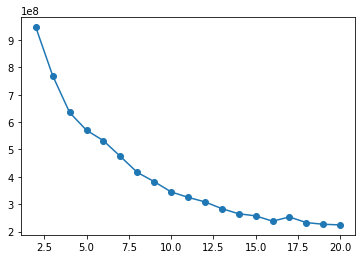

In [5]:
results = []

for k in range(2, 21):
    kmeans = KMeans(k, init='kmeans++')
    kmeans.fit(data)
    results.append(kmeans.loss)

plt.xlabel('# clusters')
plt.ylabel('loss')
plt.plot(range(2, 21), results, '-o')

From the plot we can see that for 16 labels, the cluster loss become flat and doesn't decrease anymore. Hence we can choose 16 as the optimal number of clusters. Let's try the same but with k-medoids

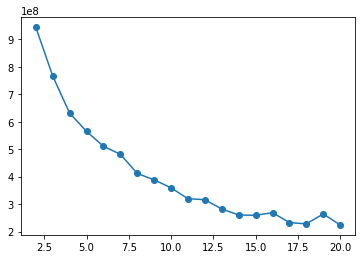

In [8]:
results = []

for k in range(2, 21):
    kmeans = KMeans(k, init='kmeans++', center_type='medoids')
    kmeans.fit(data)
    results.append(kmeans.loss)

plt.xlabel('# clusters')
plt.ylabel('loss')
plt.plot(range(2, 21), results, '-o')

Here it seems that 13 are the best number of clusters. Finally we try with c-means, let's implement it first

In [105]:
class CMeans(object):

    def __init__(self, n_clusters, fuzz=0.9, max_iter=300, tol=1e-5):

        if isinstance(n_clusters, int):
            self.n_clusters = n_clusters
        else:
            raise ValueError('expected int for n_clusters')

        self.max_iter = max_iter
        self.fuzz = fuzz
        self.tol = tol

    def fit(self, X):
        
        # save data
        self._X_fit = X

        # extract number of features and dimensions
        n_feats, dims = X.shape

        # intialize kmeans
        centers_l, U = self._initialize(X)
        U_new = np.zeros(shape=(U.shape[0], U.shape[1]))

        # epochs + old_labels
        epoch = 0

        while True:

            # compute the centers
            for i in range(self.n_clusters):
                sum_ = np.sum((U[:, i] ** self.fuzz)[:, np.newaxis] * X, axis=0)
                centers_l[i, :] = sum_ / np.sum(U[:, i] ** self.fuzz)

            # update U (error)
            for i in range(X.shape[0]):
                norm_ = np.linalg.norm(X[i] - centers_l, axis=1) ** (2. / (self.fuzz - 1.) )
                sum_ = sum([(1. / np.linalg.norm(X[i] - centers_l[n])) ** (2. / (self.fuzz - 1.)) for n in range(self.n_clusters) ])
                U_new[i] = 1. / (norm_ * sum_)


            # breaking if no change in the labels:
            if np.linalg.norm(U - U_new) < self.tol:
                break

            # breaking at maximum iteration
            if epoch == self.max_iter:
                break
            
            # update
            U = np.copy(U_new)
            epoch += 1


        # saving variables
        self.labels = np.argmax(U, axis=-1)
        self.centers = centers_l
        dists = np.dot(cdist(X, centers_l), U.T)
        self.loss = np.sum(dists.min(axis=-1))
        self.final_epoch = epoch

    def _initialize(self, X):
        """ Initialization routine """
        idxs = np.random.choice(len(X), size=self.n_clusters, replace=False)
        U = np.random.random(size=(len(X), self.n_clusters))
        U /= U.sum(axis=-1, keepdims=True)
        return X[idxs], U

    def plot_cmeans(self):

        plt.figure(figsize=(10,8))
        plt.scatter(self._X_fit[:,0], self._X_fit[:,1], c=self.labels)
        plt.plot(self.centers[:,0], self.centers[:,1], 'ro')
        plt.title(f"Final loss {self.loss:.2f}")
        plt.show()


Let's try it! We expect for low fuzz to resamble k-means, let's try it out.

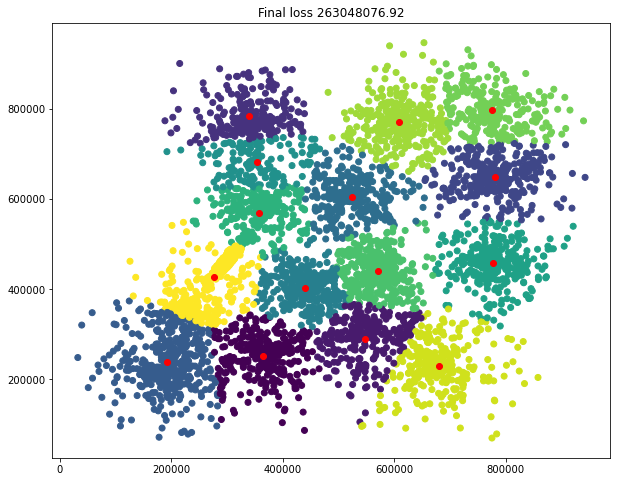

In [113]:
cmeans = CMeans(15, fuzz=1.1, max_iter=100, tol=0.01)
cmeans.fit(data)
cmeans.plot_cmeans()

And with k-means we obtain:

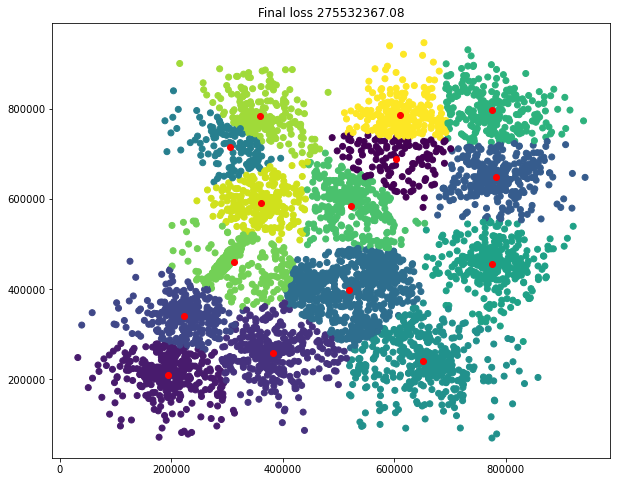

In [114]:
kmeans = KMeans(15)
kmeans.fit(data)
kmeans.plot_kmeans()

As we can see very similar clusters are found, with also a very similar final loss. Let's plot the scree test.

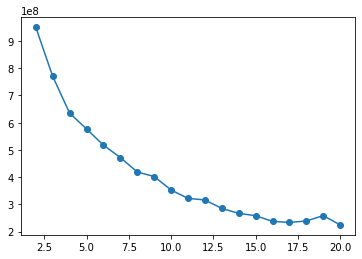

In [117]:
results = []

for k in range(2, 21):
    kmeans = CMeans(k, fuzz=2, max_iter=20, tol=0.01)
    kmeans.fit(data)
    results.append(kmeans.loss)

plt.xlabel('# clusters')
plt.ylabel('loss')
plt.plot(range(2, 21), results, '-o')